# 📂 Veri Seti Dosyalarının Kontrolü  

Bu bölümde `/kaggle/input` dizinindeki tüm dosya yollarını listeleyerek veri setimizin doğru şekilde yüklendiğini kontrol ediyoruz.  

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


# 📥 Kütüphanelerin Yüklenmesi ve Veri Setinin Okunması  

Bu bölümde projede kullanacağımız temel kütüphaneleri (NumPy, Pandas, TensorFlow, Keras) içe aktarıyoruz.  
Ayrıca Kaggle’daki **Sign Language MNIST** veri setini `train` ve `test` CSV dosyaları şeklinde okuyoruz.  

- `sign_mnist_train.csv` → Eğitim verileri  
- `sign_mnist_test.csv` → Test verileri  

TensorFlow’un log çıktıları daha temiz olması için minimum seviyeye indirildi.  


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # '3' yaparsan en sessizi olur

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
# Seçenek B: CSV'ler klasörlerin içindeyse
data_train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
data_test  = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

2025-09-25 13:00:39.074974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758805239.313636      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758805239.381810      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 🖼️ Veri Setinin Hazırlanması (X ve y Ayrımı)  

Bu bölümde:  
- Eğitim ve test veri setlerini **görüntüler (X)** ve **etiketler (y)** olarak ayırıyoruz.  
- Görseller başlangıçta düz (flattened) halde olduğu için, her bir resmi **28x28 piksel ve 1 kanal (gri ölçek)** olacak şekilde yeniden şekillendiriyoruz.  
- Veri setinin boyutlarını kontrol ederek, model eğitimine hazır olup olmadığını doğruluyoruz.  


In [3]:
training_images = data_train.iloc[:,1:].values
training_labels = data_train.iloc[:,0].values

testing_images = data_test.iloc[:,1:].values
testing_labels = data_test.iloc[:,0].values

training_images = training_images.reshape(-1,28,28,1)
testing_images = testing_images.reshape(-1,28,28,1)


print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28, 1)
(27455,)
(7172, 28, 28, 1)
(7172,)


# 🔍 Veri Görselleştirme  

Modeli eğitmeden önce eğitim veri setindeki bazı örnekleri görselleştiriyoruz.  
Bu sayede:  
- Görsellerin doğru okunup okunmadığını,  
- 28x28 gri tonlu formatta olduklarını,  
- Veri setinin çeşitliliğini gözlemleyebiliyoruz.  

Aşağıda eğitim verilerinden **10 örnek** rastgele görüntülenmiştir.  


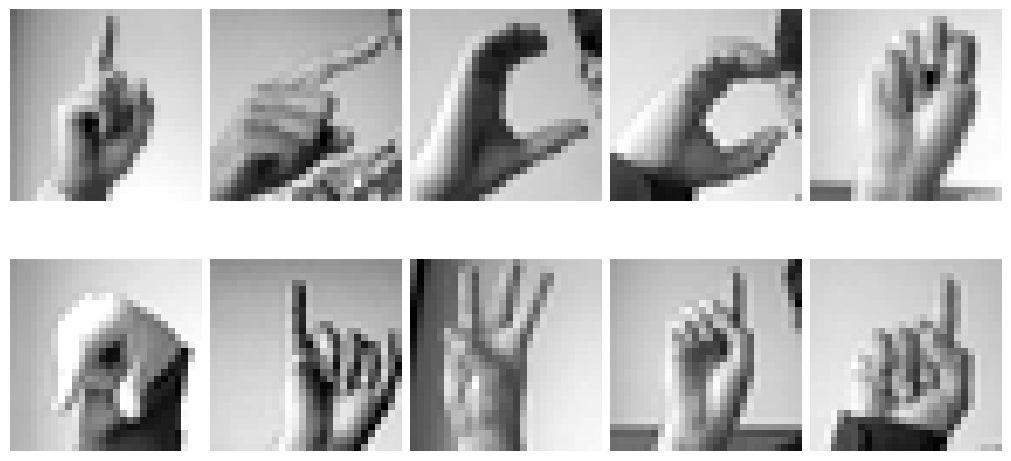

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(10, 5), constrained_layout=True)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(training_images[k].reshape(28, 28), cmap="gray")
        ax[i, j].axis("off")
        k += 1
plt.show()


# 🔄 Veri Normalizasyonu ve Data Augmentation  

Modelin daha iyi genelleme yapabilmesi için:  

- **Normalizasyon:** Piksel değerleri 0–255 aralığından 0–1 aralığına ölçeklendi.  
- **Data Augmentation:** Eğitim verisi üzerinde çeşitli dönüşümler uygulanarak veri seti çeşitlendirildi. Bu yöntem **overfitting’i azaltmaya** yardımcı olur.  

Uygulanan dönüşümler:  
- Döndürme (rotation_range=40°)  
- Yatay kaydırma (width_shift_range=0.2)  
- Dikey kaydırma (height_shift_range=0.2)  
- Kesme (shear_range=0.2)  
- Yakınlaştırma (zoom_range=0.2)  
- Yatay çevirme (horizontal_flip=True)  
- Boşluk doldurma (fill_mode='nearest')  

Test/Validation verisinde yalnızca **normalizasyon** yapılmıştır.  


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale=1 / 255
)

print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


# 🧠 Etiket Eşleme, Normalizasyon, Generator’lar ve CNN Model Eğitimi

Bu bölümde aşağıdaki adımları uyguluyoruz:

1) **Etiket Eşleme (Label Remapping)**  
   - Veri setindeki sınıf etiketleri birleşik bir uzayda toplanır ve 0..N-1 aralığına yeniden eşlenir.

2) **Şekil Doğrulama ve Normalizasyon**  
   - Görsellerin şekli güvence altına alınır (28×28×1).  
   - Piksel değerleri 0–255’ten 0–1’e ölçeklenir (gerekiyorsa otomatik tespit).

3) **ImageDataGenerator**  
   - Eğitim/validasyon/test için generator’lar hazırlanır (shuffle ayarları ile).

4) **Model Mimarisi (CNN)**  
   - İki blok **Conv2D + BN + MaxPool + Dropout**  
   - Son katmanda **Dense(softmax)** ile sınıflandırma  
   - **Adam (1e-3)**, **Sparse Categorical Crossentropy**, **accuracy** metriği

5) **Callback’ler**  
   - **EarlyStopping** (overfitting’i önlemek için)  
   - **ReduceLROnPlateau** (öğrenme oranını dinamik azaltma)  
   - **ModelCheckpoint** (en iyi modeli kaydetme)

6) **Eğitim & Değerlendirme**  
   - `model.fit(...)` ile eğitim  
   - En iyi modeli yükleyip test setinde **accuracy/loss** raporlanır.

In [6]:
import os, math, numpy as np
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

all_labels = np.concatenate([training_labels, testing_labels])
classes = np.sort(np.unique(all_labels))                 
class_to_new = {c: i for i, c in enumerate(classes)}     
training_labels = np.vectorize(class_to_new.get)(training_labels).astype(np.int64)
testing_labels  = np.vectorize(class_to_new.get)(testing_labels).astype(np.int64)
num_classes = len(classes)                                

def ensure_shape(x):
    x = np.asarray(x)
    if x.ndim == 2 and x.shape[1] == 784: x = x.reshape(-1,28,28,1)
    elif x.ndim == 3 and x.shape[1] == 28 and x.shape[2] == 28: x = x[..., np.newaxis]
    return x
training_images = ensure_shape(training_images).astype("float32")
testing_images  = ensure_shape(testing_images).astype("float32")

scale = (1.0/255.0) if training_images.max() > 1.0 else 1.0   
train_datagen = ImageDataGenerator(rescale=scale)              
val_datagen   = ImageDataGenerator(rescale=scale)
test_datagen  = ImageDataGenerator(rescale=scale)

batch_size = 64
train_gen = train_datagen.flow(training_images, training_labels, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(testing_images,  testing_labels,  batch_size=batch_size, shuffle=False)  # val için sabit sıra
test_gen  = test_datagen.flow(testing_images,  testing_labels,  batch_size=512,        shuffle=False)  # eval/predict için

# ---------- Model ----------
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes,activation="softmax"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

ckpt_path = "/kaggle/working/best_sign_model.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
]

history = model.fit(train_gen, epochs=25, validation_data=val_gen, callbacks=callbacks)

best_model = tf.keras.models.load_model(ckpt_path)
test_loss, test_acc = best_model.evaluate(test_gen, verbose=0)
print(f"Scale factor: {scale} | Best model -> Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


I0000 00:00:1758805257.119361      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758805257.119979      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758805262.024120      63 service.cc:148] XLA service 0x7abff000fe50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758805262.025281      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758805262.025313      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758805262.469369      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/429 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2041 - loss: 3.3169

I0000 00:00:1758805267.061066      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/429 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7078 - loss: 1.0694
Epoch 1: val_loss improved from inf to 34.00475, saving model to /kaggle/working/best_sign_model.keras
429/429 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7086 - loss: 1.0665 - val_accuracy: 0.0643 - val_loss: 34.0047 - learning_rate: 0.0010
Epoch 2/25
427/429 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9956 - loss: 0.0338
Epoch 2: val_loss improved from 34.00475 to 0.26837, saving model to /kaggle/working/best_sign_model.keras
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9956 - loss: 0.0338 - val_accuracy: 0.9191 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 3/25
421/429 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0153
Epoch 3: val_loss improved from 0.26837 to 0.26365, saving model to /kaggle/working/best_sign_model.keras
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9978 - loss: 0.0152 - val_accuracy: 0.9261 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 4/25

# 🔥 Grad-CAM
Bu bölümde modelin bir örneği sınıflandırırken **hangi piksellere dikkat ettiğini**  
**Grad-CAM** ile görselleştiriyoruz:

- **Son Conv2D katmanı** otomatik bulunur.
- İleri geçişte hedef konvolüsyon aktivasyonları **yakalanır**.
- `GradientTape` ile hedef sınıf skoru için **gradyanlar** hesaplanır.
- Kanal ağırlıkları ortalama alınır → ısıl harita oluşturulur ve 28×28’e ölçeklenir.
- 1 örnek için ve (varsa) ilk batch’ten **5 örnek** için üst üste bindirme (overlay) yapılır.

Using last conv layer: conv2d_1
Pred: G (1.00) | True: G


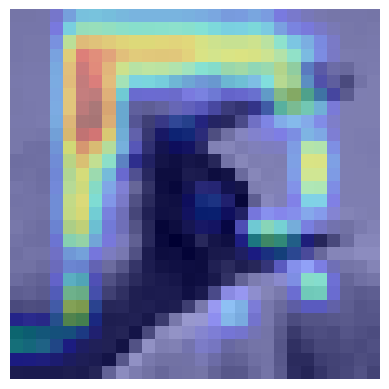

[0] Pred=G (1.00) | True=G


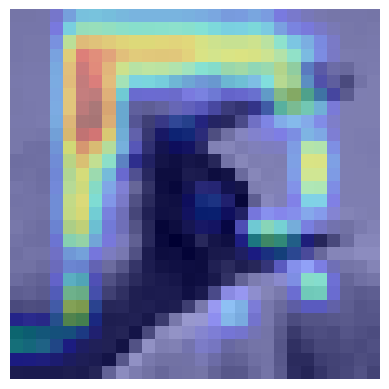

[1] Pred=F (1.00) | True=F


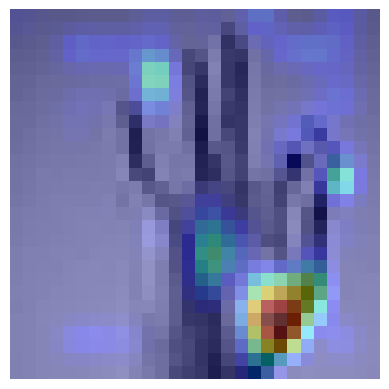

[2] Pred=K (1.00) | True=K


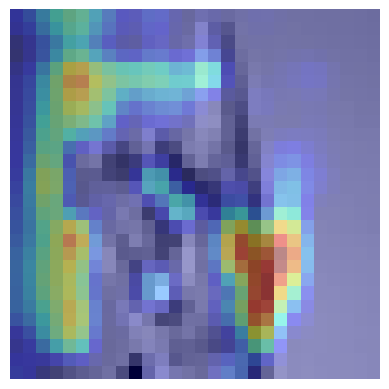

[3] Pred=A (1.00) | True=A


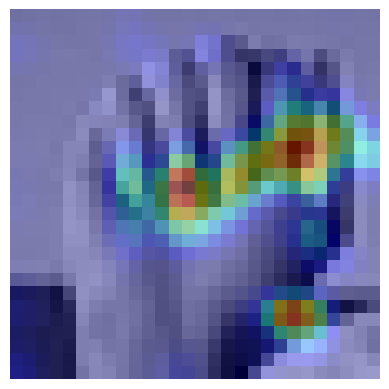

[4] Pred=D (1.00) | True=D


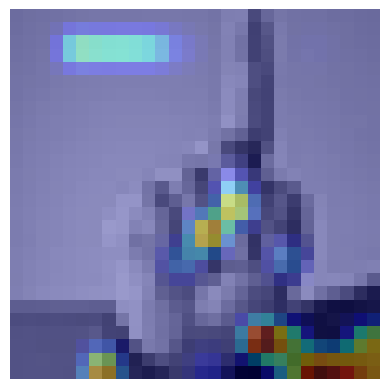

In [7]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt

def get_last_conv_layer(m):
    for layer in reversed(m.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer
        if isinstance(layer, tf.keras.Model):
            try:
                inner = get_last_conv_layer(layer)
                if inner is not None:
                    return inner
            except Exception:
                pass
    raise ValueError("Modelde Conv2D katmanı bulunamadı.")

def forward_and_capture(model, x, target_layer):
    """
    Sequential/Functional fark etmeksizin katmanları tek tek çağırır,
    target_layer aktivasyonunu ve nihai çıktıyı döndürür.
    """
    conv_act = None
    out = x
    for layer in model.layers:
        out = layer(out, training=False)
        if layer is target_layer:
            conv_act = out
    if conv_act is None:
        raise RuntimeError("Hedef katman aktivasyonu alınamadı.")
    return conv_act, out

def make_gradcam_heatmap_eager(x_batch, mdl, last_conv_layer, pred_index=None):
    """
    x_batch: (1,28,28,1) ölçeklenmiş numpy/tensor
    """
    x_tensor = tf.convert_to_tensor(x_batch, dtype=tf.float32)
    with tf.GradientTape() as tape:
        conv_out, preds = forward_and_capture(mdl, x_tensor, last_conv_layer)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_out)                       
    pooled = tf.reduce_mean(grads, axis=(0,1,2))                
    conv_out = conv_out[0]                                      
    heatmap = conv_out @ pooled[..., tf.newaxis]                
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), int(pred_index), float(preds[0, pred_index])

def show_gradcam_overlay(img28x28, heatmap, alpha=0.4, cmap="jet"):
    if img28x28.ndim == 3: img28x28 = img28x28[...,0]
    hm = (255*heatmap).astype("uint8")[..., None]
    hm = tf.image.resize(hm, (28,28)).numpy().squeeze()
    plt.imshow(img28x28, cmap="gray")
    plt.imshow(hm, cmap=cmap, alpha=alpha)
    plt.axis("off")
    plt.show()

if 'test_gen' in globals():
    x_batch, y_batch = next(test_gen)        
    x = x_batch[0]; y_true = int(y_batch[0]) 
else:
    x = testing_images[0]
    if x.ndim == 2: x = x[..., None]
    y_true = int(testing_labels[0])

x_inp = np.expand_dims(x, 0)                 

last_conv = get_last_conv_layer(best_model)
print("Using last conv layer:", last_conv.name)

heatmap, pred_idx, score = make_gradcam_heatmap_eager(x_inp, best_model, last_conv)

letters = [chr(ord('A') + i) for i in range(26)]
letters_filtered = [letters[c] for c in classes] if 'classes' in globals() else [str(i) for i in range(best_model.output_shape[-1])]
print(f"Pred: {letters_filtered[pred_idx]} ({score:.2f}) | True: {letters_filtered[y_true]}")

show_gradcam_overlay(x, heatmap)

if 'test_gen' in globals():
    for i in range(5):
        xi, yi = x_batch[i], int(y_batch[i])
        hi, pi, sc = make_gradcam_heatmap_eager(np.expand_dims(xi,0), best_model, last_conv)
        print(f"[{i}] Pred={letters_filtered[pi]} ({sc:.2f}) | True={letters_filtered[yi]}")
        show_gradcam_overlay(xi, hi)


# 📊 Eğitim ve Doğrulama Sonuçlarının Görselleştirilmesi  

Modelin eğitim süreci boyunca doğruluk (**accuracy**) ve kayıp (**loss**) değerleri  
epoch bazında takip edilmiştir.  

- Soldaki grafik: **Eğitim vs. Doğrulama Accuracy**  
- Sağdaki grafik: **Eğitim vs. Doğrulama Loss**  

Bu grafikler sayesinde:  
- Modelin **overfitting** veya **underfitting** eğilimleri tespit edilebilir.  
- Erken durdurma (EarlyStopping) callback’i ile hangi noktada eğitim durduğunu gözlemlemek mümkündür.

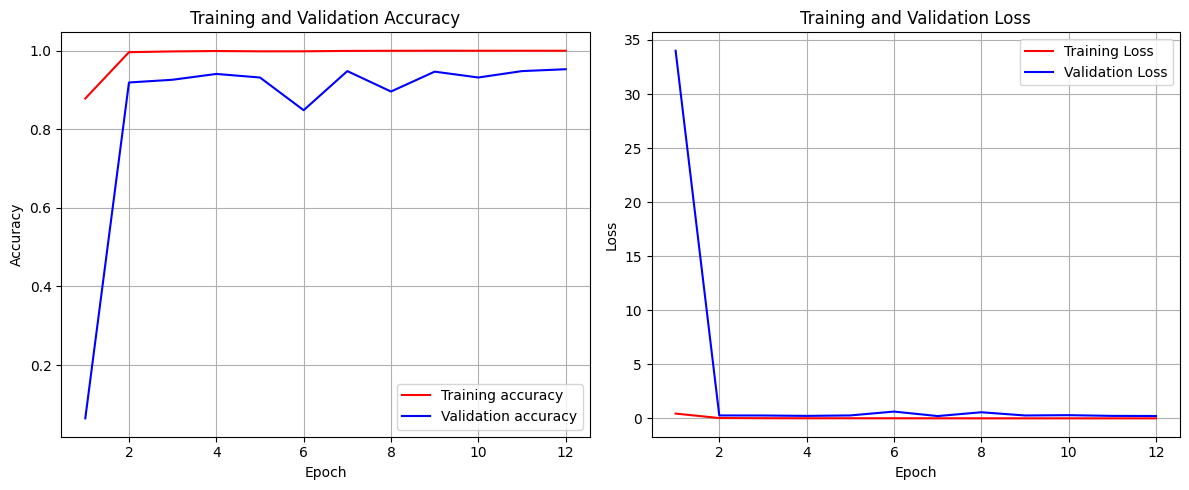

In [8]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 📌 Confusion Matrix  

Modelin test seti üzerindeki performansını sınıf bazlı incelemek için **Confusion Matrix** (karmaşıklık matrisi) kullanıyoruz.  

- Satırlar → **Gerçek etiketler**  
- Sütunlar → **Tahmin edilen etiketler**  
- Diyagonal üzerindeki değerler → Doğru tahmin edilen örnek sayıları  
- Diyagonal dışındaki değerler → Yanlış sınıflandırmalar  

Bu matris sayesinde modelin hangi sınıflarda güçlü, hangi sınıflarda zorlandığı net bir şekilde görülebilir.  

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


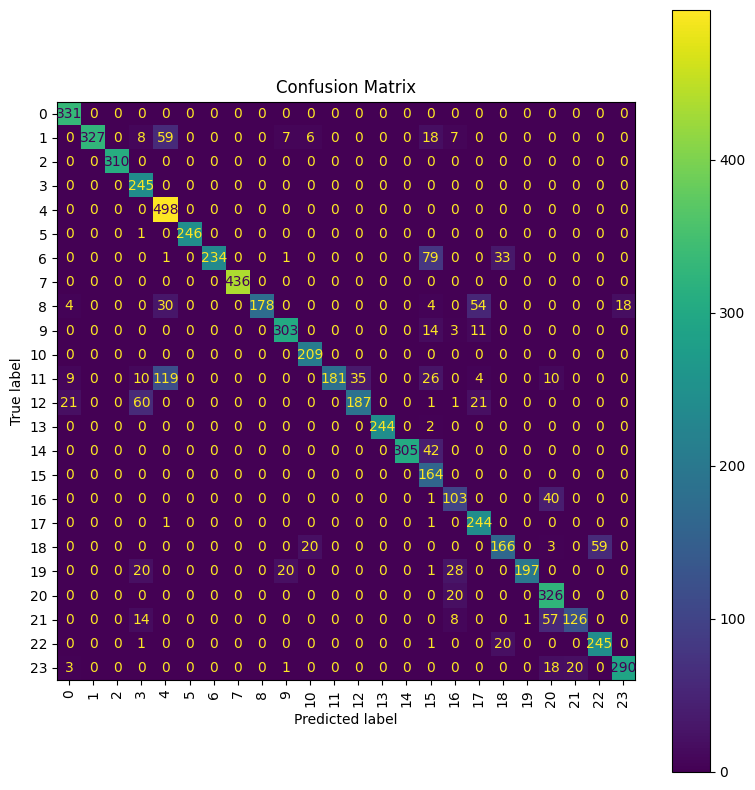

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(testing_images, batch_size=32)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(testing_labels, y_pred_labels)

classes = np.unique(np.concatenate([testing_labels, y_pred_labels]))
display_labels = classes

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=90, colorbar=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()